# Human Activity Recognition with CNN (PyTorch)

This notebook contains the full training pipeline: data loading, augmentations, model definition (MobileNetV2-style CNN), training/validation with F1-score, and test-time inference to produce `submission.csv`.

**Data is not included in the repository.** Expected local structure:
- `data/train_answers.csv` — columns: `img_id`, `target_feature`
- `data/img_train/` — training images named `{img_id}.jpg`
- `data/test.csv` — column: `img_id`
- `data/img_test/` — test images named `{img_id}.jpg`

Импортируем библиотеки

In [2]:
import os

from tqdm import tqdm
import torch
import pandas as pd
import torchvision
from torchsampler import ImbalancedDatasetSampler
import random
from sklearn.metrics import f1_score

In [ ]:
from pathlib import Path

# ---------- Config ----------
DATA_DIR = Path("data")
TRAIN_CSV = DATA_DIR / "train_answers.csv"
TEST_CSV  = DATA_DIR / "test.csv"
TRAIN_IMG_DIR = DATA_DIR / "img_train"
TEST_IMG_DIR  = DATA_DIR / "img_test"
SUBMISSIONS_DIR = Path("submissions")
SUBMISSIONS_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
NUM_CLASSES = 20
IMG_SIZE = (190, 190)


In [ ]:
import random
import numpy as np
import torch

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)


In [8]:
torch.backends.cudnn.benchmark = True
NUM_WORKERS = 0 if torch.cuda.is_available() else os.cpu_count()
print(NUM_WORKERS)

0


Класс Trainer (обучает и валидирует модель, сохраняет метрики)

In [5]:
import torch
from tqdm import tqdm

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler=None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_accuracy = 0
        self.pateince = 0
        self.best_f1 = 0
    def train(self, dataloader, epochs, test_loader):
        dataloader.dataset.is_augms = True
        size = len(dataloader.dataset)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            total_accuracy = 0

            for X, y in tqdm(dataloader):
                X, y = X.to(device), y.to(device)
                self.optimizer.zero_grad(set_to_none=True)
                output = self.model(X)
                loss = self.loss_fn(output, y)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_accuracy += output.argmax(1).eq(y).float().sum().item()

            self.train_losses.append(total_loss / size)
            self.train_accuracies.append(total_accuracy / size)
            print(f"Epoch {epoch + 1}, Training Loss: {total_loss / size}, Training Accuracy: {total_accuracy / size}")

            self.eval(test_loader)

            if self.pateince >= 20:
                print('Early Stopping triggered.')
                return

    def eval(self, dataloader):
        dataloader.dataset.is_augms = False
        self.model.eval()
        total_loss = 0
        total_accuracy = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X, y in tqdm(dataloader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                loss = self.loss_fn(output, y)
                total_loss += loss.item()
                preds = output.argmax(1)
                total_accuracy += preds.eq(y).float().sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        self.val_losses.append(total_loss / len(dataloader))
        self.val_accuracies.append(total_accuracy / len(dataloader.dataset))

        # Вычисление F1-оценки
        f1 = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' для учета дисбаланса

        if self.scheduler:
            self.scheduler.step(total_accuracy / len(dataloader.dataset))

        if self.best_f1 < f1:
            self.best_f1 = f1
            PATH = "mobileV2.pt"
            print('Model improved and saved.')
            torch.save(self.model.state_dict(), PATH)
            self.pateince = 0
        else:
            self.pateince += 1
            print(f"Улучшений не обнаружено, счетчик терпения {self.pateince}/20")

        print(f"Validation Loss: {total_loss / len(dataloader)},Validation F1 Score: {f1}")


# Модель

Класс модели MobileNetV2

In [ ]:
import collections
import warnings
from itertools import repeat
from types import FunctionType
from typing import Any
from typing import Callable, List, Optional, Sequence, Tuple, Union
from torch import nn, Tensor


def _make_ntuple(x: Any, n: int) -> Tuple[Any, ...]:
    
    if isinstance(x, collections.abc.Iterable):
        return tuple(x)
    return tuple(repeat(x, n))

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _log_api_usage_once(obj: Any) -> None:

    
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")


class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, ...]] = 3,
        stride: Union[int, Tuple[int, ...]] = 1,
        padding: Optional[Union[int, Tuple[int, ...], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, Tuple[int, ...]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., torch.nn.Module] = torch.nn.Conv2d,
    ) -> None:

        if padding is None:
            if isinstance(kernel_size, int) and isinstance(dilation, int):
                padding = (kernel_size - 1) // 2 * dilation
            else:
                _conv_dim = len(kernel_size) if isinstance(kernel_size, Sequence) else len(dilation)
                kernel_size = _make_ntuple(kernel_size, _conv_dim)
                dilation = _make_ntuple(dilation, _conv_dim)
                padding = tuple((kernel_size[i] - 1) // 2 * dilation[i] for i in range(_conv_dim))
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        _log_api_usage_once(self)
        self.out_channels = out_channels

        if self.__class__ == ConvNormActivation:
            warnings.warn(
                "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
            )


class Conv2dNormActivation(ConvNormActivation):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, int]] = 3,
        stride: Union[int, Tuple[int, int]] = 1,
        padding: Optional[Union[int, Tuple[int, int], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, Tuple[int, int]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv2d,
        )


class InvertedResidual(nn.Module):
    def __init__(
        self, inp: int, oup: int, stride: int, expand_ratio: int, norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(
                Conv2dNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                Conv2dNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        
        super().__init__()
        _log_api_usage_once(self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    @torch.inference_mode
    def inference(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Создаем модель и смотрим ее параметры

In [ ]:
model = MobileNetV2(num_classes=20).to(device)

<All keys matched successfully>

In [9]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224), device = str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

Создание класса лосса, который учитывает дисбаланс среди классов

In [10]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# Работа с данными

Класс CustomDataset (он адаптирован под адаптивную аугментацию) + loss + optimizer + scheduler

In [ ]:
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame, images_dir, augmentations_dict: dict, transforms: list):
        self.df = data_frame.reset_index(drop=True)
        self.images_dir = Path(images_dir)
        self.augmentations_dict = augmentations_dict
        self.transforms = transforms  

        self.samples = []
        for row_idx, row in self.df.iterrows():
            label = int(row["target_feature"])
            n_aug = int(self.augmentations_dict.get(label, 1))
            n_aug = max(1, n_aug)
            
            self.samples.append((row_idx, 0))
            if n_aug > 1:
                extra = self.transforms[1:] if len(self.transforms) > 1 else [self.transforms[0]]
                for k in range(n_aug - 1):
                    self.samples.append((row_idx, 1 + (k % max(1, len(extra))) ))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        row_idx, t_idx = self.samples[idx]
        row = self.df.iloc[row_idx]
        img_id = str(row["img_id"])
        label = int(row["target_feature"])
        img_path = self.images_dir / f"{img_id}.jpg"
        image = Image.open(img_path).convert("RGB")

        if t_idx == 0:
            x = self.transforms[0](image)
        else:
            extra = self.transforms[1:]
            x = extra[(t_idx - 1) % len(extra)](image)

        return x, torch.tensor(label, dtype=torch.long)


Аугментации

In [12]:
from torchvision import transforms

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

transformx = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

transformx1 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

transformx2 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

transformx4 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

transformx5 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

transformx7 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

transformx8 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])


Разделение даты

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

if not TRAIN_CSV.exists():
    raise FileNotFoundError(
        f"Missing {TRAIN_CSV}. Place the dataset under {DATA_DIR}/ or update paths in the Config cell."
    )

data = pd.read_csv(TRAIN_CSV)
train_data, val_data = train_test_split(
    data, test_size=0.15, stratify=data["target_feature"], random_state=SEED
)

print("Train size:", len(train_data))
print("Val size:", len(val_data))
print("Classes:", data["target_feature"].nunique())


Кол-во аугментаций для каждого класса 

In [14]:
counts = train_data['target_feature'].value_counts()
counts = 2000 / counts
counts = counts.round().astype(int).to_dict()
counts = {key: 8 for key in range(21)}

Демонстрация дисбаланса классов

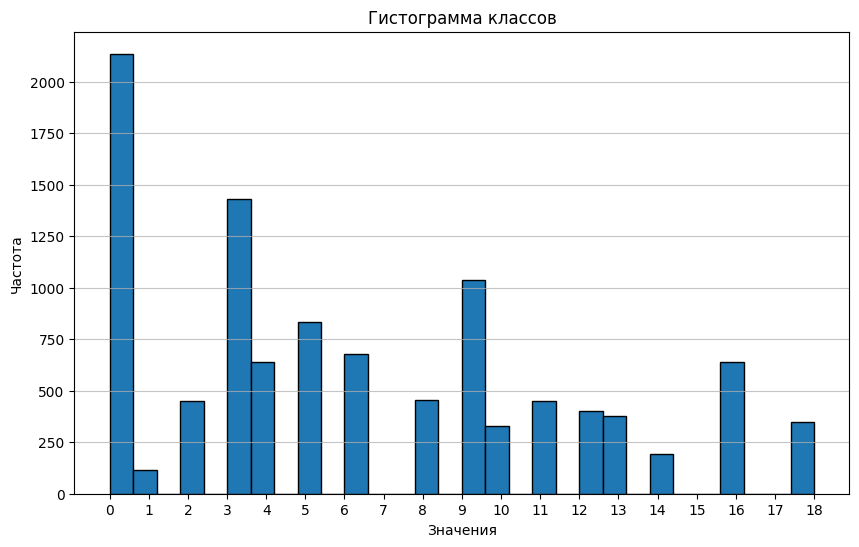

In [15]:
plt.figure(figsize=(10, 6))
train_data['target_feature'].plot.hist(bins=30, edgecolor='black')

plt.xticks(range(int(data['target_feature'].min()), int(data['target_feature'].max()) + 1))

plt.title('Гистограмма классов')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Аугментируем train выборку

In [ ]:
import numpy as np

class_counts = train_data["target_feature"].value_counts().sort_index()
max_count = class_counts.max()

MAX_AUG_PER_IMAGE = 6
augmentations_dict = {
    int(cls): int(min(MAX_AUG_PER_IMAGE, max(1, np.ceil(max_count / cnt))))
    for cls, cnt in class_counts.items()
}

train_dataset = CustomDataset(
    data_frame=train_data,
    images_dir=TRAIN_IMG_DIR,
    augmentations_dict=augmentations_dict,
    transforms=[transformx, transformx1, transformx2, transformx4, transformx5, transformx7, transformx8],
)

val_dataset = CustomDataset2(
    data_frame=val_data,
    images_dir=TRAIN_IMG_DIR,
    transform=transformx,
)
print("Train dataset size (after aug):", len(train_dataset))
print("Val dataset size:", len(val_dataset))


Loading images: 100%|████████████████████████████████████████████████████████████| 10511/10511 [04:29<00:00, 39.07it/s]


Гистаграмма после аугментаций

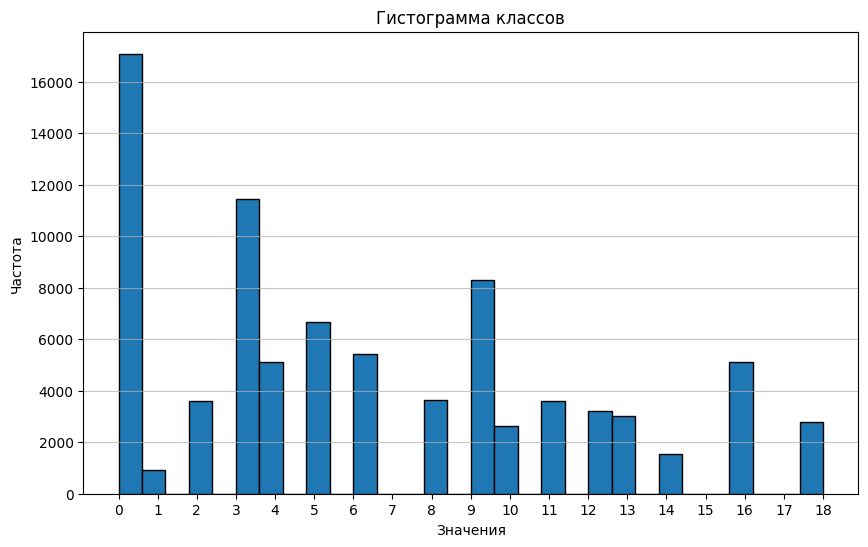

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(img_base.labels, bins=30, edgecolor='black')

plt.xticks(range(int(data['target_feature'].min()), int(data['target_feature'].max()) + 1))

plt.title('Гистограмма классов')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Изначальный класс обработки датасета (не способен на адаптивную аугментацию)

In [18]:
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset2(Dataset):
    def __init__(self, data_frame: pd.DataFrame, images_dir, transform=None):
        self.df = data_frame.reset_index(drop=True)
        self.images_dir = Path(images_dir)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_id = str(row["img_id"])
        label = int(row["target_feature"])
        img_path = self.images_dir / f"{img_id}.jpg"
        image = Image.open(img_path).convert("RGB")
        x = self.transform(image) if self.transform else image
        return x, torch.tensor(label, dtype=torch.long)

    def get_labels(self):
        return self.df["target_feature"].astype(int).tolist()


Обработка Val датасета

In [ ]:
BATCH_SIZE = 128

Создание loader

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

In [22]:
torch.cuda.empty_cache()

# Обучение

In [23]:
NUM_EPOCH = 50
trainer.train(train_loader, NUM_EPOCH, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:44<00:00,  2.31it/s]


Epoch 1, Training Loss: 0.0009391432236934998, Training Accuracy: 0.926386642564932


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.89it/s]


Model improved and saved.
Validation Loss: 0.11518441041310629,Validation F1 Score: 0.9242013471672764


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:38<00:00,  2.36it/s]


Epoch 2, Training Loss: 0.000504620630025081, Training Accuracy: 0.9539767862239559


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.95it/s]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 0.1596481556693713,Validation F1 Score: 0.9082451759145773


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:36<00:00,  2.38it/s]


Epoch 3, Training Loss: 0.000455392349185143, Training Accuracy: 0.9570212158690895


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.78it/s]


Улучшений не обнаружено, счетчик терпения 2/20
Validation Loss: 0.21187033653259277,Validation F1 Score: 0.8840033339063402


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:34<00:00,  2.39it/s]


Epoch 4, Training Loss: 0.0003826966840692659, Training Accuracy: 0.9621111216820474


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.16it/s]


Улучшений не обнаружено, счетчик терпения 3/20
Validation Loss: 0.22714289128780366,Validation F1 Score: 0.8778171102070876


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:36<00:00,  2.37it/s]


Epoch 5, Training Loss: 0.0003674008050918772, Training Accuracy: 0.9637998287508325


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.83it/s]


Улучшений не обнаружено, счетчик терпения 4/20
Validation Loss: 0.2711954067150752,Validation F1 Score: 0.8538299333572359


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:37<00:00,  2.37it/s]


Epoch 6, Training Loss: 0.000303727125892044, Training Accuracy: 0.969579488155266


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.93it/s]


Улучшений не обнаружено, счетчик терпения 5/20
Validation Loss: 0.3803423394759496,Validation F1 Score: 0.8352422501408333


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:36<00:00,  2.37it/s]


Epoch 7, Training Loss: 0.00032947489967982696, Training Accuracy: 0.96687993530587


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.79it/s]


Улучшений не обнаружено, счетчик терпения 6/20
Validation Loss: 0.3350067486365636,Validation F1 Score: 0.8457501828281531


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:34<00:00,  2.39it/s]


Epoch 8, Training Loss: 5.9733481736864327e-05, Training Accuracy: 0.9932570640281609


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.34it/s]


Улучшений не обнаружено, счетчик терпения 7/20
Validation Loss: 0.21249394714832306,Validation F1 Score: 0.8979550660405637


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:37<00:00,  2.37it/s]


Epoch 9, Training Loss: 1.917874613954609e-05, Training Accuracy: 0.9980139853486824


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.04it/s]


Улучшений не обнаружено, счетчик терпения 8/20
Validation Loss: 0.21831888457139334,Validation F1 Score: 0.8998049597016615


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:35<00:00,  2.38it/s]


Epoch 10, Training Loss: 2.3368644774935656e-05, Training Accuracy: 0.9972766625440015


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.62it/s]


Улучшений не обнаружено, счетчик терпения 9/20
Validation Loss: 0.25738799969355264,Validation F1 Score: 0.8801291082636445


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:38<00:00,  2.36it/s]


Epoch 11, Training Loss: 0.00013052563937800065, Training Accuracy: 0.986359528113405


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.76it/s]


Улучшений не обнаружено, счетчик терпения 10/20
Validation Loss: 0.34091107646624247,Validation F1 Score: 0.8502653797771499


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:33<00:00,  2.40it/s]


Epoch 12, Training Loss: 9.60214624443316e-05, Training Accuracy: 0.9890471886594996


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.88it/s]


Улучшений не обнаружено, счетчик терпения 11/20
Validation Loss: 0.3101002603769302,Validation F1 Score: 0.8659221293329056


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:36<00:00,  2.38it/s]


Epoch 13, Training Loss: 6.525643126816365e-05, Training Accuracy: 0.9922581105508514


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.40it/s]


Улучшений не обнаружено, счетчик терпения 12/20
Validation Loss: 0.2986060917377472,Validation F1 Score: 0.8676755256360703


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:34<00:00,  2.40it/s]


Epoch 14, Training Loss: 1.9658641073622204e-05, Training Accuracy: 0.9975382932166302


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.89it/s]


Улучшений не обнаружено, счетчик терпения 13/20
Validation Loss: 0.24040597329537075,Validation F1 Score: 0.8964790340909109


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:37<00:00,  2.37it/s]


Epoch 15, Training Loss: 7.925946206041004e-06, Training Accuracy: 0.9991199695557036


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.41it/s]


Улучшений не обнаружено, счетчик терпения 14/20
Validation Loss: 0.25225681662559507,Validation F1 Score: 0.8867853120475538


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:34<00:00,  2.39it/s]


Epoch 16, Training Loss: 6.512705649657823e-06, Training Accuracy: 0.9991318618590048


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.92it/s]


Улучшений не обнаружено, счетчик терпения 15/20
Validation Loss: 0.24945112119118373,Validation F1 Score: 0.8858788050018707


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:35<00:00,  2.39it/s]


Epoch 17, Training Loss: 1.4345727818571139e-05, Training Accuracy: 0.9981329083816953


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.62it/s]


Улучшений не обнаружено, счетчик терпения 16/20
Validation Loss: 0.27894910077253976,Validation F1 Score: 0.8758820088894469


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:37<00:00,  2.37it/s]


Epoch 18, Training Loss: 2.5394229826927944e-05, Training Accuracy: 0.9966582627723337


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.78it/s]


Улучшений не обнаружено, счетчик терпения 17/20
Validation Loss: 0.30051365196704866,Validation F1 Score: 0.8792701210776928


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:37<00:00,  2.36it/s]


Epoch 19, Training Loss: 2.5718373715320547e-05, Training Accuracy: 0.9967652935020455


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.93it/s]


Улучшений не обнаружено, счетчик терпения 18/20
Validation Loss: 0.3343029369910558,Validation F1 Score: 0.864645080637226


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:36<00:00,  2.38it/s]


Epoch 20, Training Loss: 8.751651855823835e-06, Training Accuracy: 0.9988345542764723


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.83it/s]


Улучшений не обнаружено, счетчик терпения 19/20
Validation Loss: 0.26573511958122253,Validation F1 Score: 0.887562660398632


100%|████████████████████████████████████████████████████████████████████████████████| 657/657 [04:35<00:00,  2.38it/s]


Epoch 21, Training Loss: 3.3254710288424692e-06, Training Accuracy: 0.9996075539910569


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.01it/s]


Улучшений не обнаружено, счетчик терпения 20/20
Validation Loss: 0.25915240893761315,Validation F1 Score: 0.8832224108300415
Early Stopping triggered.


# Графики

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(trainer.train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, trainer.train_losses, label="Train loss")
plt.plot(epochs, trainer.val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

plt.figure(figsize=(10, 6))

plt.plot(np.arange(50), trainer.train_accuracies, label='Train Loss', color='blue', marker='o')
plt.plot(np.arange(50), trainer.val_accuracies, label='Validation Loss', color='red', marker='o')

plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(50))
plt.grid(True)

plt.legend()
plt.xticks(np.arange(50), rotation=90)
plt.show()

In [25]:
PATH = "mobileV2.pt"
print('Model improved and saved.')
torch.save(trainer.model.state_dict(), PATH)

Model improved and saved.


In [ ]:
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, ids, images_dir, transform):
        self.ids = [str(x) for x in ids]
        self.images_dir = Path(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = self.images_dir / f"{img_id}.jpg"
        image = Image.open(img_path).convert("RGB")
        x = self.transform(image)
        return x, int(img_id)

if not TEST_CSV.exists():
    raise FileNotFoundError(
        f"Missing {TEST_CSV}. Place the dataset under {DATA_DIR}/ or update paths in the Config cell."
    )

test_df = pd.read_csv(TEST_CSV)
test_dataset = TestDataset(test_df["img_id"].tolist(), TEST_IMG_DIR, transformx)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


ckpt_path = Path("mobileV2.pt")
if ckpt_path.exists():
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)
model.eval()

predictions = []
ids = []

with torch.no_grad():
    for images, batch_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        predictions.extend(preds.tolist())
        ids.extend(batch_ids)

out_path = SUBMISSIONS_DIR / "submission.csv"
pd.DataFrame({"id": ids, "target_feature": predictions}).to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Predictions saved to 'submission.csv'
